In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import sys
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from multiprocessing import Pool
from functools import partial

from CrossValidation import *
from FeatureSimilarity import GetTopGenes
from MatrixFactorization import CreateLatentVariables, FactorizeMatrix, GetRepresentationError

from utils import *

In [3]:
plt.rcParams['figure.figsize'] = [8, 6]
sns.set(font_scale=1.5)

In [4]:
totalDataDF = pd.read_csv('/projects/leelab3/psturm/concatData/totalDataDF.csv', header=0, index_col=0)
binaryPathwayDF = pd.read_csv('/projects/leelab3/psturm/concatData/pathways.tsv', sep='\t', header=0)
binaryPathwayDF.set_index('Genes', inplace=True)

numReps = 100
braakIndex = 16864
geneIndices = np.arange(braakIndex)

In [5]:
dropNanDF = totalDataDF.dropna(axis=0, how='all')
dropNanDF = dropNanDF.loc[:, ~pd.isnull(dropNanDF.loc[['BRAAK']]).values[0]]
dropNanDF = dropNanDF.T.fillna(dropNanDF.mean(axis=1)).T

In [6]:
X = dropNanDF.values.T
n, g = X.shape
half_n = int(n / 2)
X_phen = dropNanDF.index.get_loc('BRAAK')
X_gene = np.arange(X_phen)

In [7]:
def ApplyIntersection(trainList, valdList, numMax=15000):
    intersection_list = np.zeros((numMax, ))
    intersection_list[0] = int(trainList[0] == valdList[0])
    for i in range(1, numMax):
        intersection_list[i] = intersection_list[i - 1] + int(np.isin(trainList[i], valdList[:min(i + 1, len(valdList))]))
        if i < len(valdList):
            intersection_list[i] += int(np.isin(valdList[i], trainList[:i]))
    return intersection_list
    
def GetIntersections(rep):
    print(rep, end=',')
    intersection_mat = np.zeros((8, 15000))
    
    V_train = np.load('/projects/leelab3/psturm/realModels/overlapModels/V_train{}.npy'.format(rep))
    V_vald = np.load('/projects/leelab3/psturm/realModels/overlapModels/V_vald{}.npy'.format(rep))
    
    intersection_mat[0, :] = ApplyIntersection(GetTopGenes(V_train, braakIndex, geneIndices, rankType='dot'),  GetTopGenes(V_vald, braakIndex, geneIndices, rankType='dot'))
    intersection_mat[1, :] = ApplyIntersection(GetTopGenes(V_train, braakIndex, geneIndices, rankType='corr'), GetTopGenes(V_vald, braakIndex, geneIndices, rankType='corr'))
    intersection_mat[2, :] = ApplyIntersection(GetTopGenes(V_train, braakIndex, geneIndices, rankType='cos'),  GetTopGenes(V_vald, braakIndex, geneIndices, rankType='cos'))
    intersection_mat[3, :] = ApplyIntersection(GetTopGenes(V_train, braakIndex, geneIndices, rankType='dist'), GetTopGenes(V_vald, braakIndex, geneIndices, rankType='dist'))
    
    randomIndices = np.loadtxt('/projects/leelab3/psturm/realData/randomIndices/perm{}.csv'.format(rep), dtype=int)
    randomIndices = randomIndices[randomIndices < n]
    trainIndices  = randomIndices[:half_n]
    valdIndices   = randomIndices[half_n:]
    trainX = X[trainIndices, :]
    valdX  = X[valdIndices, :]
    
    intersection_mat[4, :] = ApplyIntersection(GetTopGenes(trainX.T, X_phen, X_gene, rankType='dot'),  GetTopGenes(valdX.T, X_phen, X_gene, rankType='dot'))
    intersection_mat[5, :] = ApplyIntersection(GetTopGenes(trainX.T, X_phen, X_gene, rankType='corr'), GetTopGenes(valdX.T, X_phen, X_gene, rankType='corr'))
    intersection_mat[6, :] = ApplyIntersection(GetTopGenes(trainX.T, X_phen, X_gene, rankType='cos'),  GetTopGenes(valdX.T, X_phen, X_gene, rankType='cos'))
    intersection_mat[7, :] = ApplyIntersection(GetTopGenes(trainX.T, X_phen, X_gene, rankType='dist'), GetTopGenes(valdX.T, X_phen, X_gene, rankType='dist'))
    return intersection_mat

In [8]:
numProcesses = 50
p = Pool(numProcesses)
tg_zipped = p.map(GetIntersections, range(numReps))
p.close()
p.join()

46,52,24,68,47,63,29,59,22,65,49,50,25,67,48,69,26,55,28,83,45,56,37,51,43,62,39,53,16,87,35,64,33,73,42,71,32,75,8,80,41,58,40,61,34,66,15,76,21,91,7,82,30,74,18,88,27,86,19,90,23,72,4,96,3,94,20,77,0,92,44,54,1,89,36,60,5,99,2,95,38,57,6,98,9,81,31,70,17,93,13,79,14,84,10,97,11,85,12,78,

In [9]:
tg_stacked = np.stack(tg_zipped, axis=0) #of shape numReps, 4, numPlotPoints

In [15]:
def plotIndices(tg_df, names, indices, x_values, x_name, y_name, ci=None):
    dfs = []
    for i in range(len(indices)):
        dfs.append(MatToMeltDF(tg_df[:, indices[i], :], group_name = names[i], x_values=x_values, x_name=x_name, y_name=y_name))
    sns.lineplot(x=x_name, y=y_name, hue='group', data=pd.concat(dfs), ci=ci)

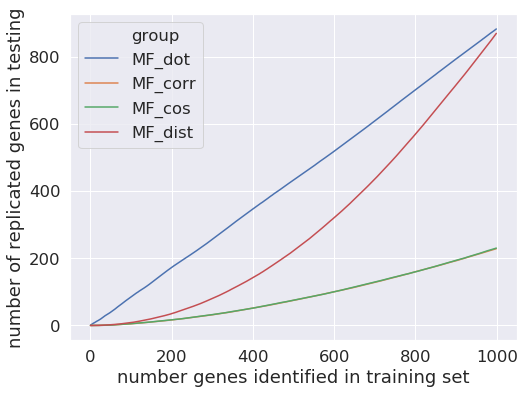

In [16]:
x_name = 'number genes identified in training set'
y_name = 'number of replicated genes in testing'
plotIndices(tg_stacked, names=['MF_dot', 'MF_corr', 'MF_cos', 'MF_dist'], indices=range(4), x_values=np.arange(1000), x_name=x_name, y_name=y_name, ci=None)

In [17]:
x_values = np.arange(100)
baseSaveDir = 'DataFrames/RealData/{}'
elastic_net_mat = pd.read_csv(baseSaveDir.format('elastic_net.csv')).values.T
elastic_net_df  = MatToMeltDF(elastic_net_mat, group_name='elastic_net', x_values=x_values, x_name=x_name, y_name=y_name)

overlap_gl_mat  = pd.read_csv(baseSaveDir.format('overlap_gl.csv')).values.T
overlap_gl_df = MatToMeltDF(overlap_gl_mat, group_name='overlap_gl', x_values=x_values, x_name=x_name, y_name=y_name)

In [18]:
MF_dot = MatToMeltDF(tg_stacked[:, 0, :], group_name='MF_dot', x_values=x_values, x_name=x_name, y_name=y_name)
MF_df = MatToMeltDF(tg_stacked[:, 3, :], group_name='MF_dist', x_values=x_values, x_name=x_name, y_name=y_name)
corr_df = MatToMeltDF(tg_stacked[:, 5, :], group_name='raw_corr', x_values=x_values, x_name=x_name, y_name=y_name)

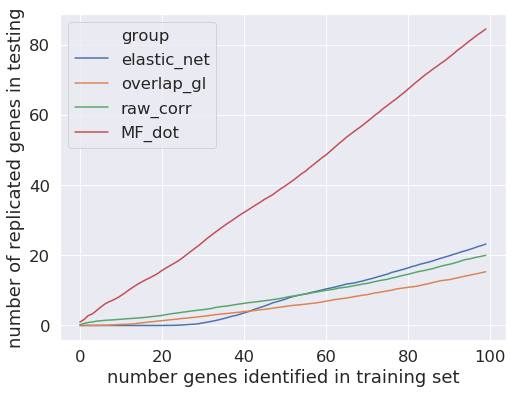

In [19]:
sns.lineplot(x=x_name, y=y_name, hue='group', 
             data=pd.concat([elastic_net_df, overlap_gl_df, corr_df, MF_dot]), ci=None)